In [11]:
using Pkg
Pkg.activate("..")  #one level up, where Project.toml lives
Pkg.instantiate()   #download/install anything missing
# Pkg.status();

  Activating project at `~/Documents/repos/JuliaExploreHRM`


In [17]:
include(joinpath(@__DIR__, "..", "hrm_common_FLUX.jl"))
using .HRMFlux
using Random, Statistics, Test
using Optimisers
using Zygote
using Flux
using Plots
rng = Random.default_rng()


TaskLocalRNG()

In [18]:

# -----------------------
# Toy data generator
# -----------------------
struct ToyGen
    w::Vector{Float32}
end

function ToyGen(d_in::Int; seed::Int=123)
    Random.seed!(seed)
    w = randn(Float32, d_in)
    return ToyGen(w)
end

"Return (x, y) with shapes (d_in, batch), (1, batch)."
function sample!(gen::ToyGen, batch::Int)
    d = length(gen.w)
    x = randn(Float32, d, batch)
    # linear + small quadratic + noise
    y_lin  = gen.w' * x                                # (1, B)
    y_quad = 0.1f0 .* sum(abs2, x; dims=1)             # (1, B)
    eps    = 0.01f0 .* randn(Float32, 1, batch)
    y      = Float32.(y_lin .+ y_quad .+ eps)
    return x, y
end

# -----------------------
# Quantizer to token IDs
# -----------------------
const LO = -3.0
const HI =  3.0

"""
Uniformly bin each element of x in [lo, hi] into 1..num_tokens.
Values outside [lo, hi] are clamped.
"""
function quantize_to_tokens(x; num_tokens::Int, lo::Real, hi::Real)
    if num_tokens ≤ 0
        error("quantize_to_tokens called with num_tokens ≤ 0; use raw floats instead.")
    end
    @assert num_tokens >= 2
    xn  = @. clamp((x - lo) / (hi - lo + eps(eltype(x))), 0, 1)
    ids = floor.(Int, xn * (num_tokens - 1)) .+ 1
    return ids
end

# -----------------------
# Configuration
# -----------------------
const CFG = (
    d_in   = 16,
    d_hid  = 64,
    d_out  = 1,
    N      = 2,      # outer HRM cycles
    T      = 3,      # inner steps (low-state rollouts)
    M      = 1,      # segments per step (kept for parity)
    batch  = 64,
    lr     = 1e-3,
    steps  = 300,
    seed   = 42,

    # input encoding
    num_tokens = 0,  # set >0 to use embeddings with IDs; 0 = raw float encoder
    d_embed    = 32,

    # transformer hyperparameters
    l_heads    = 2,
    l_ff_mult  = 4,
    h_heads    = 2,
    h_ff_mult  = 4,
    dropout    = 0.0
)

Random.seed!(CFG.seed)

# -----------------------
# Loss & training step
# -----------------------
loss_fn(yhat, y) = mean(abs2, yhat .- y)

function train_step!(models, opt_state, gen, cfg)
    x, y = sample!(gen, cfg.batch)

    x_in = cfg.num_tokens > 0 ?
           quantize_to_tokens(x; num_tokens=cfg.num_tokens, lo=LO, hi=HI) :
           x  # raw floats

    low_state, high_state = HRMFlux.init_states(cfg.batch, cfg.d_hid)

    # Closure for pullback to also carry recurrent states
    function seg_loss(m)
        yhat, low_new, high_new =
            HRMFlux.run_segment!(m, x_in, low_state, high_state; N=cfg.N, T=cfg.T, cfg=cfg)
        L = loss_fn(yhat, y)
        return L, (low_new, high_new)
    end

    (L, (low_new, high_new)), back = Zygote.pullback(seg_loss, models)
    grads = back((one(L), nothing))[1]
    opt_state, models = Optimisers.update(opt_state, models, grads)

    # Detach recurrent states across steps (kept for future M>1)
    low_state  = Zygote.dropgrad(low_new)
    high_state = Zygote.dropgrad(high_new)

    return Float32(L), models, opt_state
end

# -----------------------
# Build, sanity-check, train
# -----------------------
models    = HRMFlux.build_models(CFG)
opt_state = Optimisers.setup(Optimisers.Adam(CFG.lr), models)
gen       = ToyGen(CFG.d_in; seed=CFG.seed)

# Enable training mode so attention dropout (if any) is active
Flux.trainmode!(models)

# Quick shape sanity on blocks themselves
let d=CFG.d_hid, B=CFG.batch
    Xl = randn(Float32, d, 3, B)
    Yl = HRMFlux.forward_block(models.Lblk, Xl)
    @test size(Yl) == size(Xl)

    Xh = randn(Float32, d, CFG.T, B)
    Yh = HRMFlux.forward_block(models.Hblk, Xh)
    @test size(Yh) == size(Xh)
end

# Train
loss_hist = Float32[]
for step in 1:CFG.steps
    L, models, opt_state = train_step!(models, opt_state, gen, CFG)
    push!(loss_hist, L)
    if step % 25 == 0
        @info "step=$(step) loss=$(round(L; digits=4))"
    end
end

@test loss_hist[1] > loss_hist[end]
println("Initial loss: $(loss_hist[1])   Final loss: $(loss_hist[end])")

┌ Info: step=25 loss=1.4814
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/04_transformer_blocks_common_FLUX/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X11sZmlsZQ==.jl:136
┌ Info: step=50 loss=0.7771
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/04_transformer_blocks_common_FLUX/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X11sZmlsZQ==.jl:136
┌ Info: step=75 loss=0.4112
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/04_transformer_blocks_common_FLUX/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X11sZmlsZQ==.jl:136
┌ Info: step=100 loss=0.2465
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/04_transformer_blocks_common_FLUX/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X11sZmlsZQ==.jl:136
┌ Info: step=125 loss=0.2034
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/04_transformer_blocks_common_FLUX/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X11sZmlsZQ==.jl:136
┌ Info: step=150 loss=0.2342
└ @ Main /home/resort/Documents/repos/J

Initial loss: 21.914421   Final loss: 0.08653071


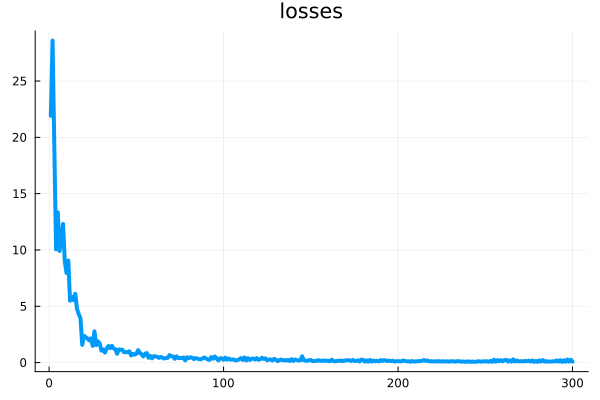

In [19]:
p = plot(loss_hist, title="losses", linewidth=4, legend=false)
savefig(p,"figures/losses.png")
display(p)